In [37]:
# standard libraries
import sys,os
#sys.path.append(os.getcwd())
sys.path.append(os.path.join(".."))
from pprint import pprint
import datetime
import numpy as np

# data and nlp
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm", disable=["ner"])
nlp.max_length = 3951751

# visualisation
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import seaborn as sns
from matplotlib import rcParams
# figure size in inches
#rcParams['figure.figsize'] = 20,10
from matplotlib import pyplot as plt

# LDA tools
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from utils import lda_utils

# warnings
import logging, warnings
warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## Read and clean data

In [20]:
#Read data
data = pd.read_csv("../data/r_wallstreetbets_posts1.csv")

start_date = [2021, 1, 1]
end_date = [2021, 1, 10]

In [21]:
#Get a subset of the dataset
data = data[["title", "created_utc"]]
#Make created utc into a datetime format
data["created_utc"] = pd.to_datetime(data["created_utc"], unit = "s").dt.date

data = data[data["created_utc"] > datetime.date(start_date[0], start_date[1], start_date[2])]
#Chose dates before 2021-03-01
data = data[data["created_utc"] < datetime.date(end_date[0], end_date[1], end_date[2])]

data = data.sort_values("created_utc")

In [38]:
data["created_utc"].max()

datetime.date(2021, 1, 9)

In [3]:
#Get a subset of the dataset
data = data[["title", "created_utc"]]
#Make created utc into a datetime format
data["created_utc"] = pd.to_datetime(data["created_utc"], unit = "s").dt.date
#Choose dates after 2021-01-10
data = data[data["created_utc"] > datetime.date(2021, 1, 10)]
#Chose dates before 2021-03-01
data = data[data["created_utc"] < datetime.date(2021, 3, 1)]
data = data.sort_values("created_utc")

## Group posts according to date

In [22]:
#This will contain all posts for each month in a list of concactinated strings
dates = []

#For every unique date
for date in data["created_utc"].unique():
    #Get the posts from that day
    posts = data[data["created_utc"]==date]["title"]
    
    #concactinate and append the posts
    dates.append(" ".join([str(post) for post in posts]))

## Preprocessing data

In [23]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(dates, min_count=3, threshold=100) 
trigram = gensim.models.Phrases(bigram[dates], threshold=100)

#Fit the models to the data
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [24]:
#Process data
data_processed = lda_utils.process_words(dates, #We are using the chunks
                                         nlp, #We are using our nlp 
                                         bigram_mod, #We fit it to our bigrams
                                         trigram_mod, #We fit it to our trigrams
                                         allowed_postags=["NOUN"]) #We are only finding nouns

In [25]:
# Create Dictionary
id2word = corpora.Dictionary(data_processed)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_processed]


## Test for best amounts of topics

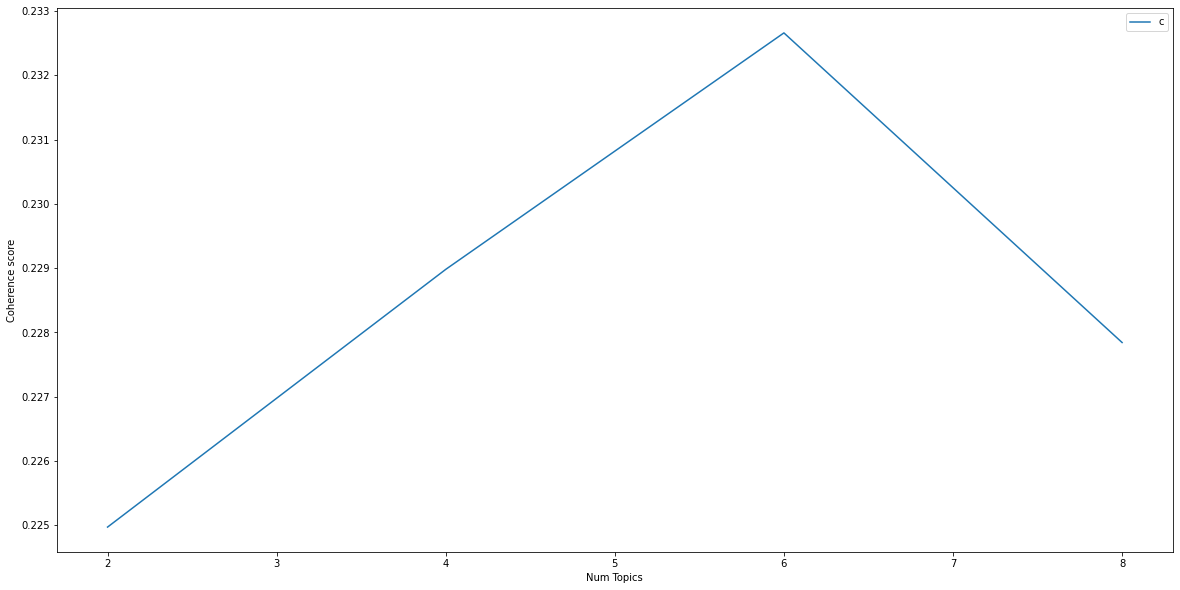

Num Topics = 2  has Coherence Value of 0.225
Num Topics = 4  has Coherence Value of 0.229
Num Topics = 6  has Coherence Value of 0.2327
Num Topics = 8  has Coherence Value of 0.2278


<Figure size 1440x720 with 0 Axes>

In [40]:
# Can take a long time to run.
#I'm starting by calculating the coherence values and perplexity, that way, I can better determine the appropriate amount of topics 
model_list, coherence_values = lda_utils.compute_coherence_values(texts=data_processed,
                                                                  corpus=corpus, 
                                                                  dictionary=id2word,  
                                                                  start=2, 
                                                                  limit=10,  
                                                                  step=2)

## Build model

In [26]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, #Our vectorized corpus - list of lists of tupples
                                       id2word=id2word, #Our gensim dictionary (mapping words to IDs)
                                       num_topics=3, #The number of topics
                                       random_state=100, #Let's create a random state to make the results reproducible
                                       chunksize=150,  # Let's set the chunksize to 150, batch data for efficiency
                                       passes=10, #Is the same as epochs, how many times do we wanne go trhough the data
                                       iterations=100, # How often are we going over a single document. (Related to passes)
                                       per_word_topics=True,  #define word distributions 
                                       minimum_probability=0.0) #Minimum value. If we get topics with zero values within a topic, we want to include it.

## Test model

In [27]:
# Compute Perplexity and print it to terminal
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
#We are testing how surprised the model is, when it encounters a new object.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=data_processed, 
                                     dictionary=id2word, 
                                     coherence='c_v')
#Print coherence the higher the better
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.133566289982541

Coherence Score:  0.2451441224949792


In [28]:
#Print topics
pprint(lda_model.print_topics())

[(0,
  '0.018*"tesla" + 0.015*"stock" + 0.014*"elon" + 0.012*"gme" + 0.012*"moon" + '
  '0.010*"tsla" + 0.010*"option" + 0.010*"day" + 0.009*"time" + 0.008*"week"'),
 (1,
  '0.014*"stock" + 0.013*"elon" + 0.012*"moon" + 0.011*"pltr" + 0.011*"call" + '
  '0.009*"time" + 0.009*"musk" + 0.008*"option" + 0.008*"papa" + 0.008*"gme"'),
 (2,
  '0.025*"gme" + 0.019*"stock" + 0.016*"moon" + 0.015*"pltr" + 0.010*"year" + '
  '0.010*"market" + 0.009*"retard" + 0.009*"day" + 0.008*"option" + '
  '0.008*"today"')]


## Create interactive board

In [29]:
#Create interactive board of topics
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
pyLDAvis.save_html(vis, "../output/lda-board_wallStreetBets.html")
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.050181 -0.034499       1        1  53.166562
0     -0.056759 -0.023750       2        1  30.277103
1      0.006578  0.058249       3        1  16.556335, topic_info=         Term        Freq       Total Category  logprob  loglift
159      elon  139.000000  139.000000  Default  30.0000  30.0000
506     tesla  159.000000  159.000000  Default  29.0000  29.0000
329      musk   85.000000   85.000000  Default  28.0000  28.0000
1772     plug   30.000000   30.000000  Default  27.0000  27.0000
543      tsla  105.000000  105.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
448     share   12.537970   83.901614   Topic3  -5.4259  -0.1025
585      year   14.094268  150.138559   Topic3  -5.3089  -0.5674
508     thank   11.862461   77.189216   Topic3  -5.4813  -0.0745
503    tendie   11.790139   82.569074   Topic3  -5.4874  -0.1480
536   trading   11.831893   85.868052   Topic3  -5.4839  -0.1836

[254 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2699      2  0.911855     access
1         1  0.394734    account
1         2  0.457061    account
1         3  0.145428    account
2329      3  0.680400  alexander
...     ...       ...        ...
585       2  0.273081       year
585       3  0.093247       year
586       1  0.254858  yesterday
586       2  0.605289  yesterday
586       3  0.127429  yesterday

[338 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

## Create dataframe for plotting

In [30]:
# Get topics from the corpus
values = list(lda_model.get_document_topics(corpus))

In [31]:
#Create list which can be splitted to a matrix
split = []
#For each list of topics in the documents
for entry in values:
    #Create list for the topics prevelance
    topic_prevelance = []
    #For each topic in the list of topics
    for topic in entry:
        #Append the topics prevalence 
        topic_prevelance.append(topic[1])
    #append list of topic prevalences 
    split.append(topic_prevelance)

In [1]:
#This is ugly, but this is the best solution I could come up with to plot dates
#Split dataframe to wide format
df = pd.DataFrame(map(list,zip(*split)))
#make it long format
df = df.transpose()
#add column with dates
df["date"] = data["created_utc"].unique()
#Set dates to be index
df = df.set_index("date")
#Make it wide formaet
#df = df.transpose()

NameError: name 'pd' is not defined

In [59]:
df

,0,1,2
date,,,
2021-01-02,0.000304,0.000292,0.999403
2021-01-03,0.000319,0.000309,0.999372
2021-01-04,0.000184,0.000179,0.999637
2021-01-05,0.000193,0.000190,0.999618
2021-01-06,0.000152,0.000151,0.999697
2021-01-07,0.000139,0.999719,0.000142
2021-01-08,0.999760,0.000118,0.000122
2021-01-09,0.999607,0.000191,0.000202


## Plot Dataframe

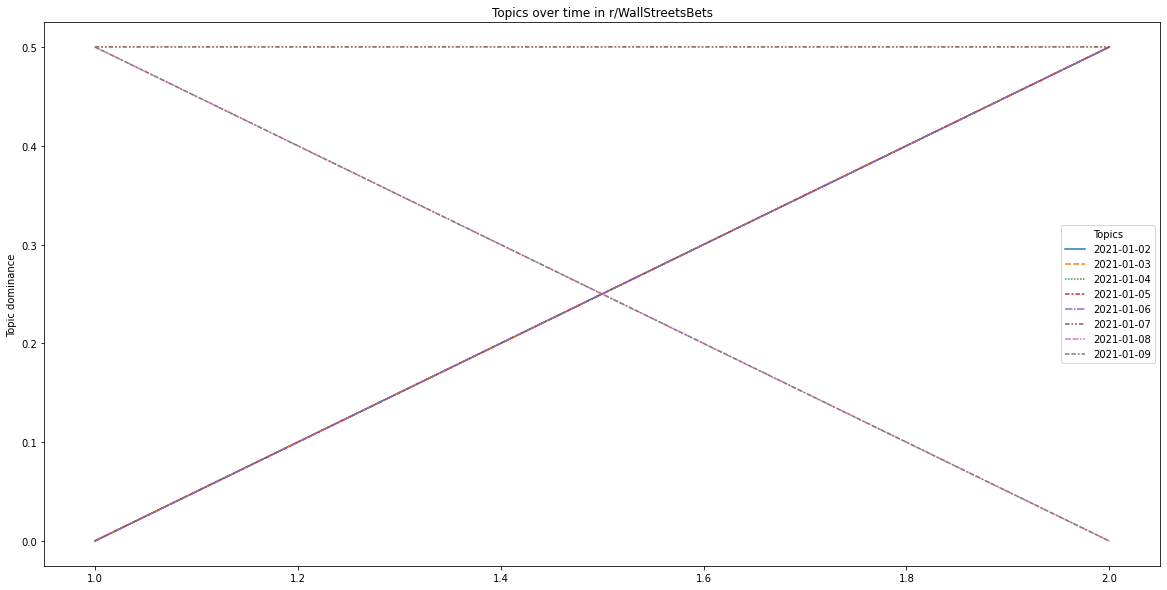

<Figure size 1440x720 with 0 Axes>

In [58]:
#plot lineplot
lineplot = sns.lineplot(data=df.rolling(2).mean(), legend = True)
#create title
lineplot.set_title("Topics over time in r/WallStreetsBets")
#set y label
lineplot.set(ylabel = "Topic dominance")
#Add legend title
plt.legend(title = "Topics")
plt.show()
#save figure
plt.savefig("../output/Topic_over_time-Lineplot.png")

In [56]:
rolling_avg = pd.Series(df).rolling(5).mean()
sns.lineplot(data = rolling_avg)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## Make dataframe for csv output

In [17]:
#Create dataframe with keywor
df_topic_keywords = lda_utils.format_topics_sentences(ldamodel=lda_model, 
                                                      corpus=corpus, 
                                                      texts=data_processed)

# Format
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['Chunk_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [18]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                      grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                      axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
#save as csv
sent_topics_sorteddf.to_csv("../output/topics_contribution.csv")